In [ ]:
# engine/default.py
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
class DefaultTrainer(SimpleTrainer):
    def __init__(self, cfg):
        # Assume these objects must be constructed in this order.
        data_loader = self.build_train_loader(cfg)
        ...    
    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable
        """
        return build_detection_train_loader(cfg)

函数调用关系如下图：
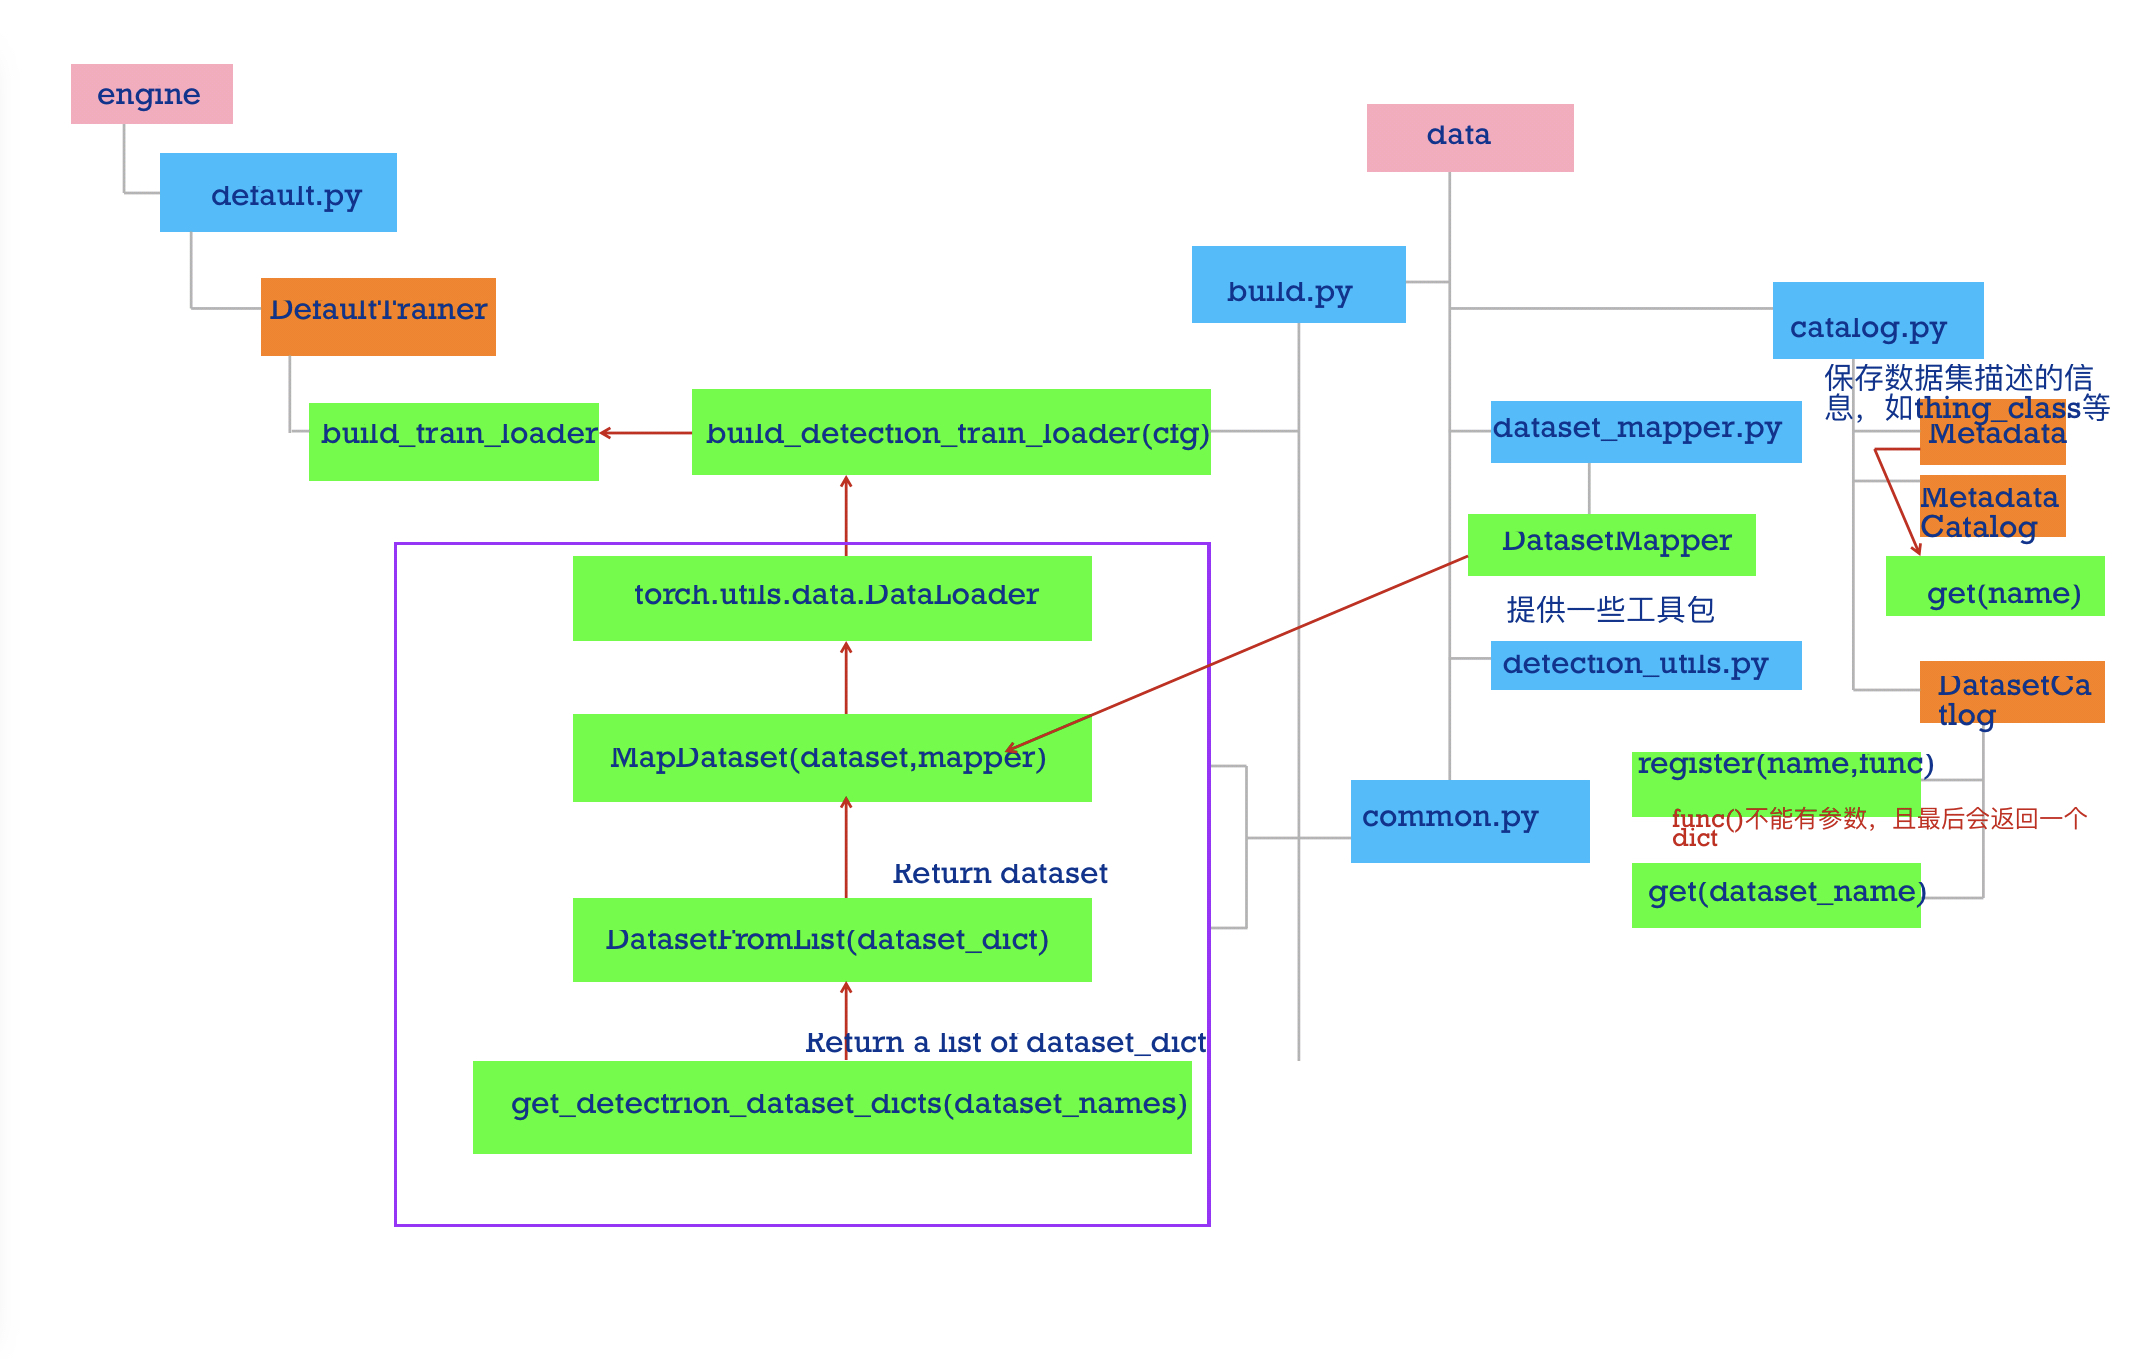

`detectron2`在构建`model`,`optimizer`和`data_loader`的时候都是在对应的`build.py`文件里实现的。我们看一下`build_detection_train_loader`是如何定义的(对应上图中紫色方框内的部分(自下往上的顺序)）：

In [ ]:
def build_detection_train_loader(cfg, mapper=None):
    """
    A data loader is created by the following steps:

    1. Use the dataset names in config to query :class:`DatasetCatalog`, and obtain a list of dicts.
    2. Start workers to work on the dicts. Each worker will:
      * Map each metadata dict into another format to be consumed by the model.
      * Batch them by simply putting dicts into a list.
    The batched ``list[mapped_dict]`` is what this dataloader will return.

    Args:
        cfg (CfgNode): the config
        mapper (callable): a callable which takes a sample (dict) from dataset and
            returns the format to be consumed by the model.
            By default it will be `DatasetMapper(cfg, True)`.

    Returns:
        a torch DataLoader object
    """
    # 获得dataset_dicts
    dataset_dicts = get_detection_dataset_dicts(
        cfg.DATASETS.TRAIN,
        filter_empty=True,
        min_keypoints=cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE
        if cfg.MODEL.KEYPOINT_ON
        else 0,
        proposal_files=cfg.DATASETS.PROPOSAL_FILES_TRAIN if cfg.MODEL.LOAD_PROPOSALS else None,
    )

    # 将dataset_dicts转化成torch.utils.data.Dataset
    dataset = DatasetFromList(dataset_dicts, copy=False)

    # 进一步转化成MapDataset，每次读取数据时都会调用mapper来对dict进行解析
    if mapper is None:
        mapper = DatasetMapper(cfg, True)
    dataset = MapDataset(dataset, mapper)

    # 采样器
    sampler_name = cfg.DATALOADER.SAMPLER_TRAIN
    if sampler_name == "TrainingSampler":
        sampler = samplers.TrainingSampler(len(dataset))
        ...
    batch_sampler = build_batch_data_sampler(
        sampler, images_per_worker, group_bin_edges, aspect_ratios
    )

    # 数据迭代器 data_loader
    data_loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        batch_sampler=batch_sampler,
        collate_fn=trivial_batch_collator,
        worker_init_fn=worker_init_reset_seed,
    )
    return data_loader

### 获得dataset_dicts
`get_detection_dataset_dicts(dataset_names)`函数需要传递的一个重要参数是`dataset_names`,这个参数其实就是一个字符串，用来指定数据集的名称。通过这个字符串，该函数会调用`data/catalog.py`的`DatasetCatalog`类来进行解析得到一个包含数据信息的字典。

解析的原理是：`DatasetCatalog`有一个字典`_REGISTERED`，默认已经注册好了例如`coco`,`voc`这些数据集的信息。如果你想要使用你自己的数据集，那么你需要在最开始前你需要定义你的数据集名字以及定义一个函数(这个函数不需要传参，而且最后会返回一个`dict`，该`dict`包含你的数据集信息)，举个栗子：

In [ ]:
from detectron2.data import DatasetCatalog
my_dataset_name = 'apple'

# get_dicts():将数据集转成COCO数据集格式
def get_dicts():
    ...
    return dict

DatasetCatalog.register(my_dataset_name, get_dicts)

当然，如果你的数据集已经是COCO的格式了，那么你也可以使用如下方法进行注册

In [ ]:
from detectron2.data.datasets import register_coco_instances
my_dataset_name = 'apple'
register_coco_instances(my_dataset_name, {}, "json_annotation.json", "path/to/image/dir")

另外需要注意的是一个数据集其实是可以由两个类来定义的，一个是前面介绍了的`DatasetCatalog`,另一个是`MetadataCatalog`。

`MetadataCatalog`的作用是记录数据集的一些特征，这样我们就可以很方便的在整个代码中获取数据集的特征信息。在注册`DatasetCatalog`后，我们可以按如下栗子对`MetadataCatalog`进行注册并定义我们后面可能会用到的属性特征：

In [ ]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]

# 也可以这样
MetadataCatalog.get("my_dataset").set("thing_classes",["person", "dog"])

注意：如果你的数据集名字未注册过，`MetadataCatalog.get`会自动进行注册，然后会自动设置你所设定的属性值。

其实`MetadataCatalog`还有其他的特征属性可以设置，如`stuff_classes`,`stuff_colors`等等。你可能会好奇`thing_classes`和`stuff_classes`有什么区别，区别如下：

- 抽象解释：`thing_classes`用于指定`instance-level`任务，`stuff_classes`用于`semantic segmentation`任务。
- 具体解释：像椅子，书这种可数的东西，就可以理解成`thing`,所以用于`instance-level`;而雪、天空这种不可数的就理解成`stuff`,所以用于`semantic segmentation`。参考On Seeing Stuff: The Perception of Materials by Humans and Machines
最后，`get_detection_dataset_dicts`会返回一个包含若干个`dict`的`list`，之所以是`list`是因为参数`dataset_names`也是一个`list`，这样我们就可以制定多个names来同时对数据进行读取。

### 解析成DatasetFromList

`DatasetFromList(dataset_dict)`函数定义在`detectron2/data/common.py`中，它其实就是一个`torch.utils.data.Dataset`类，其源码如下

In [ ]:
class DatasetFromList(data.Dataset):
    """
    Wrap a list to a torch Dataset. It produces elements of the list as data.
    """

    def __init__(self, lst: list, copy: bool = True):
        """
        Args:
            lst (list): a list which contains elements to produce.
            copy (bool): whether to deepcopy the element when producing it,
                so that the result can be modified in place without affecting the
                source in the list.
        """
        self._lst = lst
        self._copy = copy

    def __len__(self):
        return len(self._lst)

    def __getitem__(self, idx):
        if self._copy:
            return copy.deepcopy(self._lst[idx])
        else:
            return self._lst[idx]

### 将DatasetFromList转化成MapDataset

其实`DatasetFromList`和`MapDataset`都是`torch.utils.data.Dataset`的子类，那他们的区别是什么呢？很简单，区别就是后者使用了`mapper`。

在解释`mapper`是什么之前我们首先要知道的是，在`detectron2`中，一张图片对应的是一个`dict`，那么整个数据集就是`list[dict]`。之后我们再看`DatsetFromList`，它的`__getitem__`函数非常简单，它只是简单粗暴地就返回了指定`idx`的元素。显然这样是不行的，因为在把数据扔给模型训练之前我们肯定还要对数据做一定的处理，而这个工作就是由`mapper`来做的，默认情况下使用的是`detectron2/data/dataset_mapper.py`中定义的`DatasetMapper`，如果你需要自定义一个`mapper`也可以参考这个写。

`DatasetMapper(cfg, is_train=True)`
我们继续了解一下`DatasetMapper`的实现原理，首先看一下官方给的定义：

`A callable which takes a dataset dict in Detectron2 Dataset format, and map it into a format used by the model.`

简单概括就是这个类是可调用的(`callable`),所以在下面的源码中可以看到定义了`__call__`方法。

该类主要做了这三件事：
```
The callable currently does the following:

Read the image from "file_name"
Applies cropping/geometric transforms to the image and annotations
Prepare data and annotations to Tensor and :class:Instances
```
源码如下（有删减）

In [15]:
class DatasetMapper:
    def __init__(self, cfg, is_train=True):
        # 读取cfg的参数
        ...

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
        # 1. 读取图像数据
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)

        # 2. 对image和box等做Transformation
        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            ...
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # 3.将数据转化成tensor格式
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        ...

        return dataset_dict

In [ ]:
class MapDataset(data.Dataset):
    def __init__(self, dataset, map_func):
        self._dataset = dataset
        self._map_func = PicklableWrapper(map_func)  # wrap so that a lambda will work

        self._rng = random.Random(42)
        self._fallback_candidates = set(range(len(dataset)))

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        retry_count = 0
        cur_idx = int(idx)

        while True:
            data = self._map_func(self._dataset[cur_idx])
            if data is not None:
                self._fallback_candidates.add(cur_idx)
                return data

            # _map_func fails for this idx, use a random new index from the pool
            retry_count += 1
            self._fallback_candidates.discard(cur_idx)
            cur_idx = self._rng.sample(self._fallback_candidates, k=1)[0]

            if retry_count >= 3:
                logger = logging.getLogger(__name__)
                logger.warning(
                    "Failed to apply `_map_func` for idx: {}, retry count: {}".format(
                        idx, retry_count
                    )
                )

- `self._fallback_candidates`是一个`set`,它的特点是其中的元素是独一无二的，定义这个的作用是记录可正常读取的数据索引，因为有的数据可能无法正常读取，所以这个时候我们就可以把这个坏数据的索引从`_fallback_candidates`中剔除，并随机采样一个索引来读取数据。
- `__getitem__`中的逻辑就是首先读取指定索引的数据，如果正常读取就把该所索引值加入到`_fallback_candidates`中去；反之，如果数据无法读取，则将对应索引值删除，并随机采样一个数据，并且尝试3次，若3次后都无法正常读取数据，则报错，但是好像也没有退出程序，而是继续读数据，可能是以为总有能正常读取的数据吧hhh。

In [ ]:
class DataLoader(object):
        ...

    def __next__(self):
        if self.num_workers == 0:  
            indices = next(self.sample_iter)  # Sampler
            batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset
            if self.pin_memory:
                batch = _utils.pin_memory.pin_memory_batch(batch)
            return batch

在阅读上面代码前，我们可以假设我们的数据是一组图像，每一张图像对应一个`index`，那么如果我们要读取数据就只需要对应的`index`即可，即上面代码中的`indices`，而选取`index`的方式有多种，有按顺序的，也有乱序的，所以这个工作需要`Sampler`完成，现在你不需要具体的细节，后面会介绍，你只需要知道`DataLoader`和`Sampler`在这里产生关系。

那么`Dataset`和`DataLoader`在什么时候产生关系呢？没错就是下面一行。我们已经拿到了`indices`，那么下一步我们只需要根据`index`对数据进行读取即可了。

再下面的`if`语句的作用简单理解就是，如果`pin_memory=True`,那么`Pytorch`会采取一系列操作把数据拷贝到`GPU`，总之就是为了加速。

综上可以知道`DataLoader`，`Sampler`和`Dataset`三者关系如下：
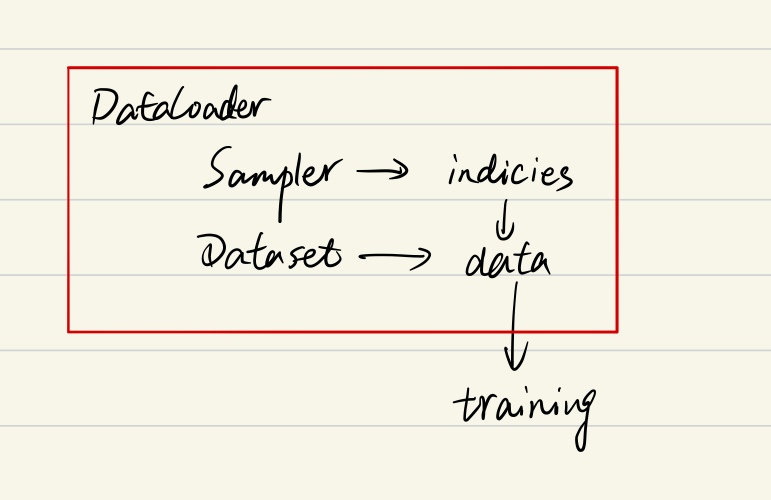

### Sampler

#### 参数传递
要更加细致地理解Sampler原理，我们需要先阅读一下DataLoader 的源代码，如下：

In [ ]:
class DataLoader(object):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=default_collate,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None)

可以看到初始化参数里有两种`sampler：sampler`和`batch_sampler`，都默认为`None`。前者的作用是生成一系列的`index`，而`batch_sampler`则是将`sampler`生成的`indices`打包分组，得到一个又一个`batch`的`index`。例如下面示例中，`BatchSampler`将`SequentialSampler`生成的`index`按照指定的`batch size`分组。

需要注意的是`DataLoader`的部分初始化参数之间存在互斥关系，这个你可以通过阅读源码更深地理解，这里只做总结：

- 如果你自定义了`batch_sampler`,那么这些参数都必须使用默认值：`batch_size, shuffle,sampler,drop_last.`
- 如果你自定义了`sampler`，那么`shuffle`需要设置为False
- 如果`sampler`和`batch_sampler`都为`None`,那么`batch_sampler`使用`Pytorch`已经实现好的`BatchSampler`,而`sampler`分两种情况：
  - 若`shuffle=True`,则`sampler=RandomSampler(dataset)`
  - 若`shuffle=False`,则`sampler=SequentialSampler(dataset)`

In [13]:
import torch

In [10]:
data_source = [1,5,78,9,68]
b = torch.utils.data.SequentialSampler(data_source) # 顺序采样器
for x in b:
    print(x)

0
1
2
3
4


### RandomSampler
Arguments:

- data_source:
- num_samples: default ALL, the number of samples to draw
- replacement: 若为True，则表示可以重复采样,这样可能导致有的样本采样不到。所以此时我们可以设置num_samples来增加采样数量使得每个样本都可能被采样到。

In [6]:
data_source = [1,5,78,9,68]
b = torch.utils.data.RandomSampler(data_source, num_samples=10, replacement=True)
for x in b:
    print(x)

2
3
3
0
2
1
0
4
3
2


### SubsetRandomSampler
这个采样器常见的使用场景是将训练集划分成训练集和验证集

In [ ]:
n_train = len(train_dataset)
split = n_train // 3
indices = random.shuffle(list(range(n_train)))
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])
train_loader = DataLoader(..., sampler=train_sampler, ...)
valid_loader = DataLoader(..., sampler=valid_sampler, ...)

### WeightedRandomSampler
参数作用同上面的RandomSampler

Arguments:

- weights (sequence):a sequence of weights, not necessary summing up to one
- num_samples (int)
- replacement (bool)

### BatchSampler

前面的采样器每次都只返回一个索引，但是我们在训练时是对批量的数据进行训练，而这个工作就需要BatchSampler来做。也就是说BatchSampler的作用就是将前面的Sampler采样得到的索引值进行合并，当数量等于一个batch大小后就将这一批的索引值返回。

Arguments:

- sampler
- batch_size (int): size of mini-batch
- drop_last (bool): If True, the sampler will drop the last batch if its size would be less than ``batch_size``

In [12]:
list(torch.utils.data.sampler.BatchSampler(torch.utils.data.sampler.SequentialSampler(range(10)), batch_size=3, drop_last=False))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

### Dataset

In [ ]:
class Dataset(object):
    def __init__(self):
        ...

    def __getitem__(self, index):
        return ...
        
    def __len__(self):
        return ...

上面三个方法是最基本的，其中`__getitem__`是最主要的方法，它规定了如何读取数据。但是它又不同于一般的方法，因为它是`python built-in`方法，其主要作用是能让该类可以像`list`一样通过索引值对数据进行访问。假如你定义好了一个`dataset`，那么你可以直接通过`dataset[0]`来访问第一个数据。`Dataloader`的`__next__`函数可以看到`DataLoader`对数据的读取其实就是用了`for`循环来遍历数据,如下：

In [ ]:
class DataLoader(object): 
    ... 
     
    def __next__(self): 
        if self.num_workers == 0:   
            indices = next(self.sample_iter)  
            batch = self.collate_fn([self.dataset[i] for i in indices]) # this line 
            if self.pin_memory: 
                batch = _utils.pin_memory.pin_memory_batch(batch) 
            return batch

我们仔细看可以发现，前面还有一个`self.collate_fn`方法，这个是干嘛用的呢?在介绍前我们需要知道每个参数的意义：

- `indices:` 表示每一个`iteration`，`sampler`返回的`indices`，即一个`batch size`大小的索引列表
- `self.dataset[i]:` 前面已经介绍了，这里就是对第`i`个数据进行读取操作，一般来说`self.dataset[i]=(img, label)`
看到这不难猜出`collate_fn`的作用就是将一个`batch`的数据进行合并操作。默认的`collate_fn`是将`img`和`label`分别合并成`imgs`和`labels`，所以如果你的`__getitem__`方法只是返回 `img, label`,那么你可以使用默认的`collate_fn`方法，但是如果你每次读取的数据有`img, box, label`等等，那么你就需要自定义`collate_fn`来将对应的数据合并成一个`batch`数据，这样方便后续的训练步骤。
